In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import os


# Loading the St Jude dataset

## Metadata
The RNA-seq dataset consistes of ~5k samples. Metadata is stored in a tab-separated table: `"../data/SAMPLE_INFO.txt.gz"`. Load the metadata using `pd.read_csv()`. What columns are there? What kind of data do we need?

In [3]:

meta = pd.read_csv("../data/SAMPLE_INFO.txt.gz", sep="\t")

In [4]:

meta.columns

Index(['file_path', 'file_id', 'subject_name', 'sample_name', 'sample_type',
       'sequencing_type', 'file_type', 'description', 'file_size',
       'sj_dataset_accessions', 'sj_embargo_date', 'sj_long_disease_name',
       'attr_age_at_diagnosis', 'attr_diagnosis', 'attr_sex', 'attr_ethnicity',
       'attr_race', 'attr_oncotree_disease_code',
       'attr_library_selection_protocol', 'attr_read_length',
       'attr_sequencing_platform', 'attr_read_type',
       'attr_inferred_strandedness', 'sj_publication_titles',
       'sj_pub_accessions', 'sj_pmid_accessions', 'attr_subtype_biomarkers',
       'sj_associated_diagnoses', 'attr_germline_sample',
       'attr_diagnosis_group', 'sj_ega_accessions', 'sj_access_unit',
       'sj_diseases', 'sj_datasets', 'sj_pipeline_name', 'sj_pipeline_version',
       'attr_tissue_preservative', 'attr_lab_strandedness',
       'sj_disease_hierarchy_code', 'sj_disease_hierarchy_name'],
      dtype='object')

### Making a unique index

Set `sample_name` as index on the data frame. Is it a unique index? Why not? Have a look at the `'attr_library_selection_protocol'` column. How could we make `sample_name` a unique index? Let's be cheap and just keep the first occurrence of sample-name for today. Hint: `meta.drop_duplicates(subset=..., keep=...)`

In [5]:

meta['attr_library_selection_protocol']

0       Total
1       Total
2       Total
3       Total
4       Total
        ...  
5324    Total
5325    PolyA
5326    Total
5327    PolyA
5328    Total
Name: attr_library_selection_protocol, Length: 5329, dtype: object

In [6]:

meta['file_name'] = meta['file_path'].apply(lambda x: os.path.basename(x))
meta = meta.drop_duplicates(subset='file_name', keep='first').set_index('sample_name')

## Count Matrix

To save us some time, we already loaded all the individual featureCounts files and aggregated them into one big table. Load `'../data/stjude_count_matrix.tsv.gz'` into a new dataframe and set `'gene'` as index. Have a look at the data.

In [7]:

df = pd.read_csv('../data/stjude_count_matrix.tsv.gz', sep='\t').set_index('gene')

In [8]:
df

,SJACT030424_D1,SJACT030437_D1,SJACT030487_D1,SJALCL031066_D1,SJAML030210_D2,SJACT030812_D1,SJAML030416_D1,SJAML030430_D1,SJAML030601_D1,SJAML030612_D1,...,SJAML007124_D1,SJAML074191_D1,SJAML074192_D1,SJAML074193_D1,SJAML074194_D1,SJAML074195_D1,SJAML074196_D1,SJAML074197_D2,SJMLL001_D,SJMLL002_D
gene,,,,,,,,,,,,,,,,,,,,,
A1BG,61,24,1,6,0,1,19,9,19,26,...,55,61,51,56,7,20,91,8,80,179
A1BG-AS1,101,249,31,91,6,13,232,58,55,177,...,227,495,366,289,109,131,535,21,732,334
A1CF,212,0,0,0,10,0,0,0,3,1,...,0,3,0,0,0,0,0,83,3,0
A2M,3618,29688,3033,1713,1650,7528,68,18,138,175,...,10,101,127,3,99,202,0,1483,48,23
A2M-AS1,119,129,149,91,24,218,192,22,256,103,...,4,647,244,13,85,5,78,24,60,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
__no_feature,117437699,33112204,25828240,11134565,6968508,27922870,21869145,17690955,23999571,53583169,...,40342858,31821742,25116818,21935626,20711315,30102386,37251090,41253042,70638683,23215487
__ambiguous,579021,2284705,1529835,1131378,8086196,3299238,5460481,2074964,4142913,3806144,...,7057651,5537865,9978398,9876318,10461943,10743837,7964869,1435214,12150326,489719
__too_low_aQual,1318,0,1,264,1839,455,0,264,281,5,...,0,0,0,0,0,0,0,0,0,0


## Convert to AnnData object

The anndata object uses cells/samples as rows and genes as columns. Transpose our count matrix and use it to construct an `sc.AnnData()` object. Make sure gene names are unique (hint: `ad.var_names_make_unique()`)

In [9]:

ad = sc.AnnData(df.T)
ad.var_names_make_unique()


### simple pre-filtering

Unlike sc data, we do not need to filter cells/samples, as these have already been curated. However, many of the genes here are very lowly expressed. Let's get an overview of the count distribution of all genes by summing across samples. We want a new column in `var` to hold the result: `ad.var['n_counts']` (hint: the numbers themselves are stored in `ad.X` and it has all the basic math operations such as `.sum(axis=...)` etc. We would also really like a log scaled version of that `log10_counts` (hint: `np.log10()`).

In [10]:

ad.var['n_counts'] = ad.X.sum(axis=0)
ad.var['log10_counts'] = np.log10(ad.var['n_counts'] + 1)

<Axes: xlabel='log10_counts', ylabel='Count'>

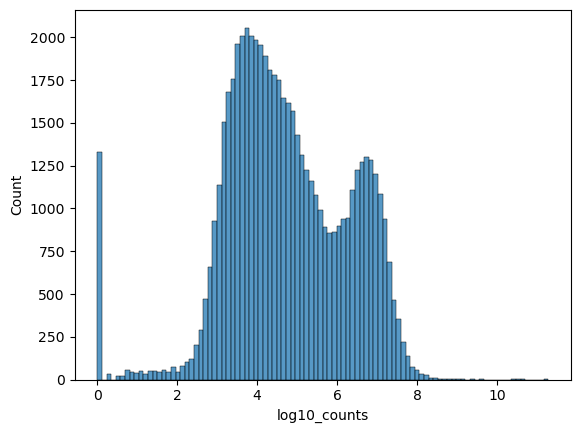

In [11]:

sns.histplot(data=ad.var, x='log10_counts')

Based on the overall-expression histogram, it would seem that we can safely remove genes that have less than 100 counts. Since these are bulk-samples, we can actually be a bit more demanding. Let's keep genes that have at least 100 counts in at least 10 samples. How many genes pass this filter?

In [12]:

expressed_genes = (ad.X >= 100).sum(axis=0) >= 10
expressed_genes.sum()

np.int64(33943)

Ok great, let's subset the adata object to the expressed_genes and forget the rest. Normal subsetting creates a view() of the selected data. We therefore need to make a `.copy()`.

In [13]:

ad = ad[:, expressed_genes].copy()

Since variation in sequencing depth can sometimes lead to spurious signals, let's keep an eye on that as well by recording `n_counts` and `log10_counts` per sample as well and store that in `.obs`.

<Axes: xlabel='log10_counts', ylabel='Count'>

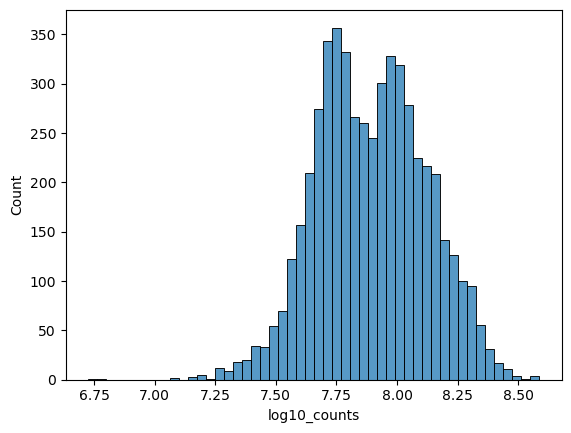

In [14]:

ad.obs['n_counts'] = ad.X.sum(axis=1)
ad.obs['log10_counts'] = np.log10(ad.obs['n_counts'] + 1)
sns.histplot(data=ad.obs, x='log10_counts')

### adding the metadata

Now that we have the counts in good shape it is time to add the metadata. Since we largely have metadata about the samples, these columns should go into `.obs`. That is just a dataframe, so we can actually use `.join()` if we like, or just copy the columns we are interested in. Let us add the following columns to obs and fill it from the metadata table: `['sample_type', 'sj_diseases', 'sj_disease_hierarchy_code', 'sj_disease_hierarchy_name', 'attr_library_selection_protocol']`

In [15]:

# join
new_obs = ad.obs.join(meta[['sample_type', 'sj_diseases', 'sj_disease_hierarchy_code', 'sj_disease_hierarchy_name', 'attr_library_selection_protocol']])
ad.obs = new_obs
# copy st Jude metadata columns
#for c in ['sample_type', 'sj_diseases', 'sj_disease_hierarchy_code', 'sj_disease_hierarchy_name', 'attr_library_selection_protocol']:
#    m = meta.loc[ad.obs_names, c]
#    ad.obs[c] = m

let's simplify the metadata a little bit. `sj_disease_hierarchy_code` can be split on the `|` character. The first two sub-strings can be used to populate new `.obs` columns `tissue` and `system`, respectively (or if you have better names, go for it). The first part of `sj_long_disease_name` up to a ',' (if there is one) makes for a useful `tumor` column entry. Edit `.obs` accordingly (hint: `.apply(lambda x :x.split(...))`)

In [39]:

ad.obs['tissue'] = ad.obs['sj_disease_hierarchy_code'].apply(lambda x: x.split('|')[0])
ad.obs['system'] = ad.obs['sj_disease_hierarchy_code'].apply(lambda x: x.split('|')[1])
ad.obs['tumor'] = meta['sj_long_disease_name'].apply(lambda x: x.split(',')[0])

Let's get an overview of how many samples of each tumor we have in the dataset. A horizontal barplot of sample-numbers would be great! Tumors that only occur once can be omitted to declutter the plot. hint: `.value_counts()`. We are going to need extra vertical space on that plot. So creating figure and axes objects first is a good idea. hint: `plt.subplots(figsize=(8, 20))`

<Axes: xlabel='count', ylabel='tumor'>

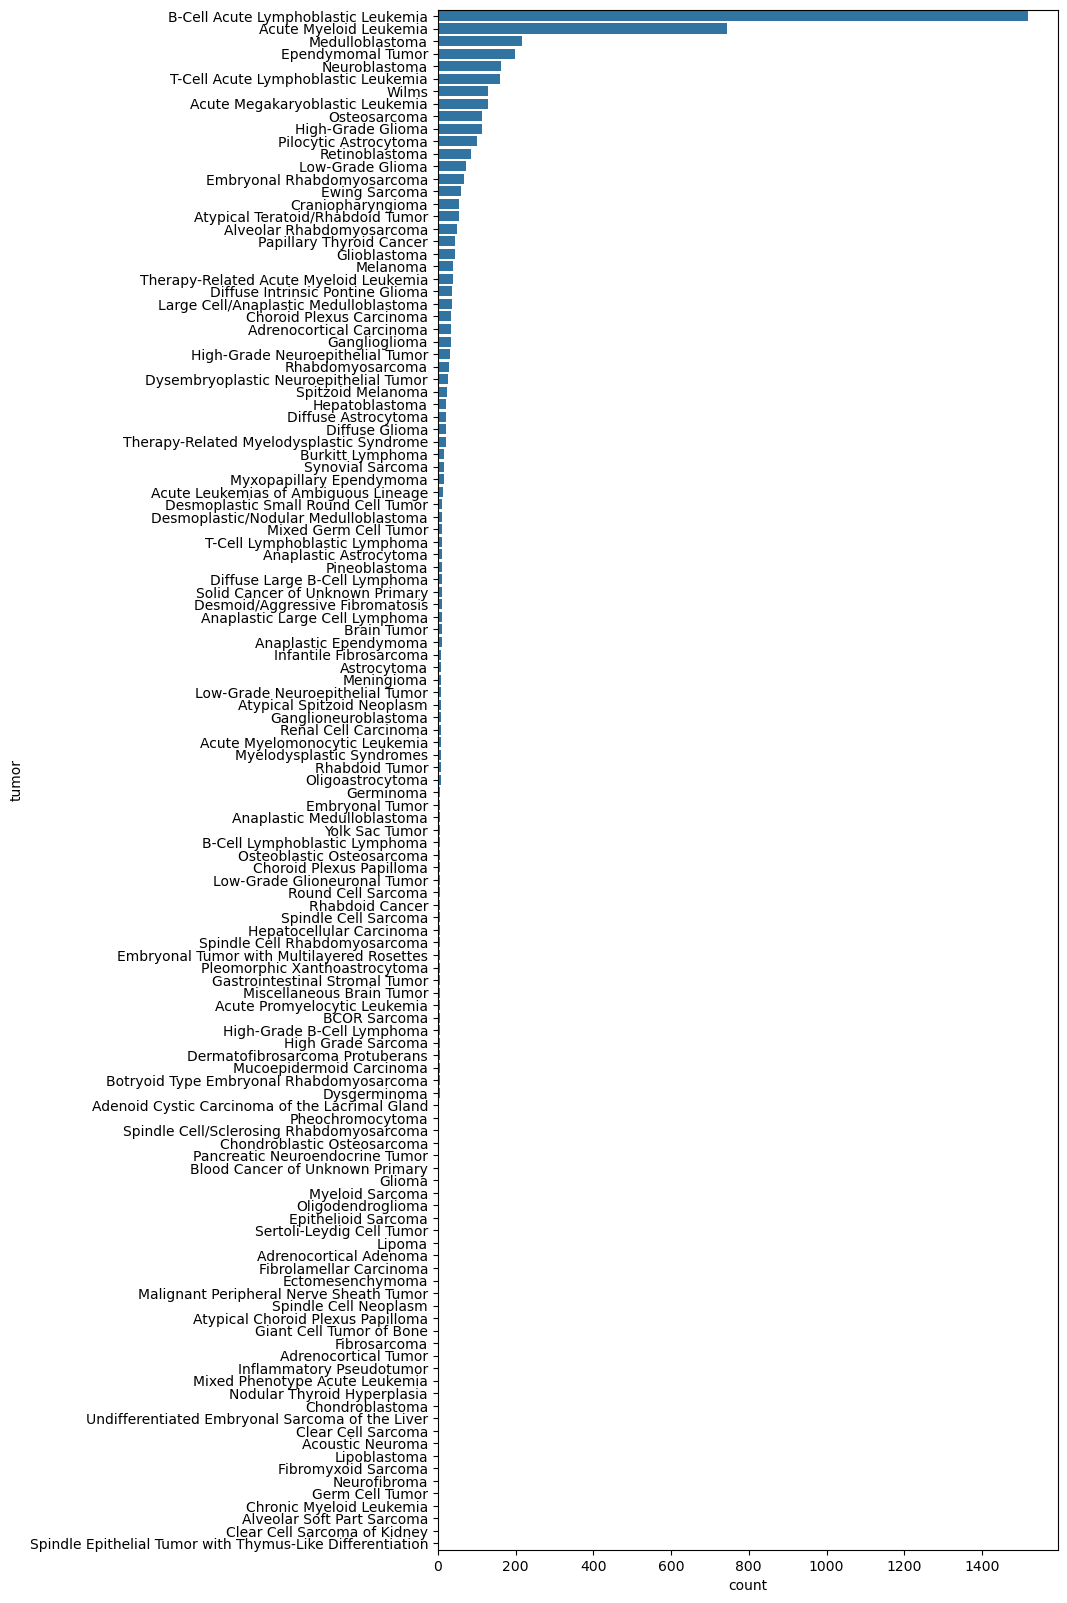

In [41]:

dcounts = ad.obs['tumor'].value_counts()
fig, ax = plt.subplots(figsize=(8, 20))
sns.barplot(dcounts.loc[dcounts > 2], orient='h', ax=ax)

## Storing the AnnData object

Great! We now have counts and metadata in one nice AnnData object. Time to save it. Let's use `'../results/stjude_adata.h5ad'` as filename. (hint: `ad.write_h5ad(..)`)

In [42]:

ad.write_h5ad('../results/stjude_adata.h5ad')